In [1]:
import os
import pandas
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR10
from torchvision import transforms
import torchvision.transforms.functional as F
from torchvision.utils import make_grid

plt.rcParams["savefig.bbox"] = 'tight'

In [2]:
class CNN_Cifar10(nn.Module):
    def __init__(self):
        super(CNN_Cifar10, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=2, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(9248,128)
        )

        self.z_mean = nn.Linear(128, 16)
        self.z_log_var = nn.Linear(128, 16)

        self.decoder = nn.Sequential(
            nn.Linear(16, 128),
            nn.Linear(128, 9248),
            nn.Unflatten(1, (32, 17, 17)),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, kernel_size=2),
            nn.Tanh()
        )

    def forward(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)
        dec = self.decoder(lat)
        
        return dec, mu, lv

    def reparam(self, mu, lv):
        std = torch.exp(0.5 * lv)
        eps = torch.randn_like(std)
        return mu + std * eps

In [3]:
transform = transforms.Compose(
    [
        # transforms.RandomHorizontalFlip(),
        # transforms.CenterCrop(148),
        # transforms.Resize(64),
        transforms.ToTensor()
    ]
)

trainset = CIFAR10(root='/media/airesearch/khoibaocon/git/data', train=True, download=True, transform=transform)
train_dl = DataLoader(trainset, batch_size=256, shuffle=True, num_workers=24)
validset = CIFAR10(root='/media/airesearch/khoibaocon/git/data', train=False, download=True, transform=transform)
valid_dl = DataLoader(validset, batch_size=256, shuffle=False, num_workers=24)

print(len(trainset), len(validset))
print(len(train_dl), len(valid_dl))

Files already downloaded and verified
Files already downloaded and verified
50000 10000
196 40


In [4]:
def gaussian_kls(mu, logvar):
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return torch.mean(kld_loss)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = CNN_Cifar10().to(device)

optimizer = Adam(params = model.parameters(), lr = 0.005)

epochs = 30

kld_w = 256/len(trainset)

scheduler = CosineAnnealingLR(optimizer, epochs*len(train_dl))

recon_loss = nn.MSELoss(reduction='none')

def loss_fn(recon_x, x):
    return torch.mean(torch.sum(recon_loss(recon_x, x), dim=(1,2,3)))

In [6]:
for epoch in range(epochs):
    model.train()
    tr_total_loss = {
        "rec_loss" : 0,
        "kl_loss" : 0
    }
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img, train_mu, train_lv = model(train_img)
        train_rec_loss = loss_fn(gen_img, train_img)
        train_kl_loss = gaussian_kls(train_mu, train_lv)
        train_loss = train_rec_loss + kld_w * train_kl_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss["rec_loss"] += train_rec_loss.item()
        tr_total_loss["kl_loss"] += train_kl_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = {
            "rec_loss" : 0,
            "kl_loss" : 0
        }
        for valid_img, _ in tqdm(valid_dl):
            valid_img = valid_img.to(device)

            gen_img, valid_mu, valid_lv = model(valid_img)
            valid_rec_loss = loss_fn(gen_img, valid_img)
            valid_kl_loss = gaussian_kls(valid_mu, valid_lv)
            valid_loss = valid_rec_loss + valid_kl_loss

            va_total_loss["rec_loss"] += valid_rec_loss.item()
            va_total_loss["kl_loss"] += valid_kl_loss.item()

    print(f"Epoch: {epoch} - TrainRecLoss: {tr_total_loss['rec_loss']/len(train_dl)} - ValidRecLoss: {va_total_loss['rec_loss']/len(valid_dl)}")
    print(f"Epoch: {epoch} - TrainDivLoss: {tr_total_loss['kl_loss']/len(train_dl)} - ValidDivLoss: {va_total_loss['kl_loss']/len(valid_dl)}")

100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 29.48it/s]


Epoch: 0 - TrainRecLoss: 109.38514911885164 - ValidRecLoss: 105.47907848358155
Epoch: 0 - TrainDivLoss: 89.7549451071845 - ValidDivLoss: 75.46609535217286


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 30.72it/s]


Epoch: 1 - TrainRecLoss: 63.112832984145804 - ValidRecLoss: 63.42591228485107
Epoch: 1 - TrainDivLoss: 74.21311995447898 - ValidDivLoss: 64.22562408447266


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 29.02it/s]


Epoch: 2 - TrainRecLoss: 59.640985761369976 - ValidRecLoss: 58.786610221862794
Epoch: 2 - TrainDivLoss: 67.73868428444376 - ValidDivLoss: 63.8189040184021


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 28.19it/s]


Epoch: 3 - TrainRecLoss: 54.545452701802155 - ValidRecLoss: 52.97093801498413
Epoch: 3 - TrainDivLoss: 66.8284310516046 - ValidDivLoss: 65.75994548797607


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 29.17it/s]


Epoch: 4 - TrainRecLoss: 52.699398741430166 - ValidRecLoss: 52.49604768753052
Epoch: 4 - TrainDivLoss: 65.59931930230589 - ValidDivLoss: 65.97336273193359


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 27.14it/s]


Epoch: 5 - TrainRecLoss: 53.25736283282844 - ValidRecLoss: 52.21004056930542
Epoch: 5 - TrainDivLoss: 65.25145258222308 - ValidDivLoss: 65.10077314376831


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 28.53it/s]


Epoch: 6 - TrainRecLoss: 51.48807800059416 - ValidRecLoss: 53.83974180221558
Epoch: 6 - TrainDivLoss: 64.47157565914854 - ValidDivLoss: 64.58925933837891


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 27.81it/s]


Epoch: 7 - TrainRecLoss: 51.432544688789214 - ValidRecLoss: 53.52290849685669
Epoch: 7 - TrainDivLoss: 64.06175422668457 - ValidDivLoss: 63.70472240447998


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 29.07it/s]


Epoch: 8 - TrainRecLoss: 51.146745662299956 - ValidRecLoss: 52.831704998016356
Epoch: 8 - TrainDivLoss: 63.91170762509716 - ValidDivLoss: 62.198411750793454


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 29.34it/s]


Epoch: 9 - TrainRecLoss: 50.933492524283274 - ValidRecLoss: 51.75809917449951
Epoch: 9 - TrainDivLoss: 63.6972667149135 - ValidDivLoss: 62.80073804855347


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 30.37it/s]


Epoch: 10 - TrainRecLoss: 50.67743019181855 - ValidRecLoss: 51.65654821395874
Epoch: 10 - TrainDivLoss: 63.47399758319465 - ValidDivLoss: 64.14318866729737


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 28.68it/s]


Epoch: 11 - TrainRecLoss: 50.48923947859784 - ValidRecLoss: 51.85711307525635
Epoch: 11 - TrainDivLoss: 63.498673692041514 - ValidDivLoss: 61.6488299369812


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 29.50it/s]


Epoch: 12 - TrainRecLoss: 50.340775937450175 - ValidRecLoss: 51.977829456329346
Epoch: 12 - TrainDivLoss: 63.42670066989198 - ValidDivLoss: 63.706022548675534


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 29.42it/s]


Epoch: 13 - TrainRecLoss: 50.078038137786244 - ValidRecLoss: 51.380745029449464
Epoch: 13 - TrainDivLoss: 63.50990787817507 - ValidDivLoss: 63.040683555603025


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 30.03it/s]


Epoch: 14 - TrainRecLoss: 49.955877751720195 - ValidRecLoss: 51.33994007110596
Epoch: 14 - TrainDivLoss: 63.460526407981405 - ValidDivLoss: 63.301274108886716


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 29.05it/s]


Epoch: 15 - TrainRecLoss: 49.79179403733234 - ValidRecLoss: 51.29443597793579
Epoch: 15 - TrainDivLoss: 63.371923524506236 - ValidDivLoss: 62.70947980880737


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 27.73it/s]


Epoch: 16 - TrainRecLoss: 49.668433734348845 - ValidRecLoss: 51.161816692352296
Epoch: 16 - TrainDivLoss: 63.48391505650112 - ValidDivLoss: 62.50308904647827


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 28.51it/s]


Epoch: 17 - TrainRecLoss: 49.46751164416877 - ValidRecLoss: 51.1020149230957
Epoch: 17 - TrainDivLoss: 63.58427139204375 - ValidDivLoss: 63.59694900512695


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 29.41it/s]


Epoch: 18 - TrainRecLoss: 49.371018078862406 - ValidRecLoss: 51.15970726013184
Epoch: 18 - TrainDivLoss: 63.61808237737539 - ValidDivLoss: 62.53573875427246


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 28.84it/s]


Epoch: 19 - TrainRecLoss: 49.22933181451292 - ValidRecLoss: 50.973020267486575
Epoch: 19 - TrainDivLoss: 63.53598446748695 - ValidDivLoss: 63.40835762023926


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 28.74it/s]


Epoch: 20 - TrainRecLoss: 49.07293551308768 - ValidRecLoss: 50.9390151977539
Epoch: 20 - TrainDivLoss: 63.748924469461244 - ValidDivLoss: 62.00537462234497


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.13it/s]


Epoch: 21 - TrainRecLoss: 48.93377555146509 - ValidRecLoss: 50.9356556892395
Epoch: 21 - TrainDivLoss: 63.69260058111074 - ValidDivLoss: 63.76251230239868


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 28.18it/s]


Epoch: 22 - TrainRecLoss: 48.79180256201296 - ValidRecLoss: 50.80362720489502
Epoch: 22 - TrainDivLoss: 63.70935802070462 - ValidDivLoss: 63.72188844680786


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 27.57it/s]


Epoch: 23 - TrainRecLoss: 48.69490909576416 - ValidRecLoss: 50.825122928619386
Epoch: 23 - TrainDivLoss: 63.93694562328105 - ValidDivLoss: 63.5249002456665


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 27.49it/s]


Epoch: 24 - TrainRecLoss: 48.57943174790363 - ValidRecLoss: 50.76983957290649
Epoch: 24 - TrainDivLoss: 63.92381644735531 - ValidDivLoss: 63.871687698364255


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 29.18it/s]


Epoch: 25 - TrainRecLoss: 48.492970816943114 - ValidRecLoss: 50.79121494293213
Epoch: 25 - TrainDivLoss: 64.13250860875966 - ValidDivLoss: 63.765390968322755


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 29.60it/s]


Epoch: 26 - TrainRecLoss: 48.41146181067642 - ValidRecLoss: 50.76854848861694
Epoch: 26 - TrainDivLoss: 64.13026492449703 - ValidDivLoss: 64.0768518447876


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 30.13it/s]


Epoch: 27 - TrainRecLoss: 48.32848181043352 - ValidRecLoss: 50.76506233215332
Epoch: 27 - TrainDivLoss: 64.21886514157666 - ValidDivLoss: 64.21257486343384


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 28.23it/s]


Epoch: 28 - TrainRecLoss: 48.288831477262534 - ValidRecLoss: 50.76528253555298
Epoch: 28 - TrainDivLoss: 64.27837379611269 - ValidDivLoss: 64.2660418510437


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 27.70it/s]

Epoch: 29 - TrainRecLoss: 48.25833768260722 - ValidRecLoss: 50.76683702468872
Epoch: 29 - TrainDivLoss: 64.31125487113485 - ValidDivLoss: 64.25871200561524


In [7]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

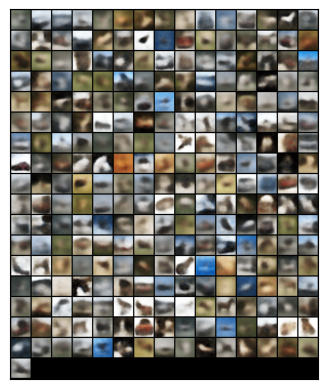

In [11]:
test_input, _ = next(iter(valid_dl))
test_input = test_input.to(device)

model.eval()
with torch.no_grad():
    recons, _, _ = model(test_input)

grid = make_grid(recons, nrow = 15)
show(grid)

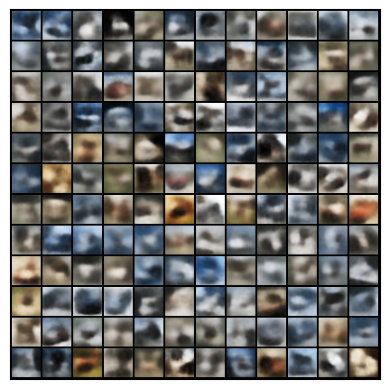

In [9]:
z = torch.randn(144, 16).to(device)

samples = model.decoder(z)

grid = make_grid(samples, nrow=12)
show(grid)